In [163]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

("CRWD", 4.53, 0.28, 0.25)
("NET", 0.53, 0.3, 0.1)

class MonteCarloDCF:

    def __init__(self, ticker, fcf, initial_growth, margin):
        self.ticker = ticker
        self.fcf = fcf
        self.initial_growth = initial_growth
        self.margin = margin
        self.growth_traj = None
        self.fair_prices = []

    def growth_Model(self, terminal_growth, growth_years, target_margin, margin_years):
        self.growth_traj = [terminal_growth] * max(growth_years, margin_years)
        for i in range(growth_years):
            self.growth_traj[i] = 1+self.initial_growth-i*(self.initial_growth-terminal_growth)/growth_years
            self.growth_traj[i] += + np.random.uniform(-0.2,0.2)*self.growth_traj[i]
        if self.margin < target_margin:
            margin_growth = self.margin_Model(target_margin, margin_years)
            for i in range(margin_years):
                 self.growth_traj[i] *= margin_growth[i]

    def margin_Model(self, target_margin, margin_years):
        future_margins = np.linspace(self.margin, target_margin, margin_years+1)
        margin_growth = []
        for i in range(1, margin_years+1):
            margin_growth.append(future_margins[i]/future_margins[i-1])
        return margin_growth

    def discounted(self, discount_rate, years, terminal_growth):
        future_cash = self.fcf
        discounted_cash = 0
        for i in range(years):
            future_cash *= self.growth_traj[i]
            discounted_cash += future_cash / (1+discount_rate)**(i+1)
        terminal_cash = future_cash * (1+terminal_growth) / (discount_rate-terminal_growth)
        discounted_cash += terminal_cash / (1+discount_rate)**years
        return discounted_cash

    def monteCarlo(self, n):
        for _ in range(n):
            terminal_growth = np.random.uniform(0.03, 0.05) 
            growth_years = round(np.random.uniform(3.51, 12.49)) # years before drop to terminal growth
            target_margin = np.random.uniform(0.25, 0.35) # what margin will expanded to 
            margin_years = round(np.random.uniform(1.51, 5.49)) # years of margin expansion
            discount_rate = np.random.uniform(0.07, 0.12)
            years = max(growth_years, margin_years)
            self.growth_Model(terminal_growth, growth_years, target_margin, margin_years)
            fair_price = self.discounted(discount_rate, years, terminal_growth)
            self.fair_prices.append(fair_price)
        median = round(np.median(self.fair_prices))
        price_5th = round(np.percentile(self.fair_prices, 5))
        price_95th = round(np.percentile(self.fair_prices, 95))
        print(f"Median fair price: ${median}")
        print(f"5th percentile fair price: ${price_5th}")
        print(f"95th percentile fair price: ${price_95th}")
        market_price = round(yf.Ticker(self.ticker).history(period="1d")["Close"].iloc[-1])
        print(f"Market price: ${market_price}")
        
        # market_price = yf.Ticker(self.ticker).history(period="1d")["Close"].iloc[-1]  # Get the latest closing pric
        # plt.hist(self.fair_prices, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Fair Prices')
        # plt.axvline(median, color='red', linestyle='dashed', linewidth=2, label=f'Median: {round(median)}')
        # plt.axvline(market_price, color='purple', linestyle='dashed', linewidth=2, label=f'Median: {round(market_price)}')
        # plt.xlim(price_5th, price_95th)  # Limit x-axis to 5th and 95th percentiles
        # plt.xlabel('Fair Price')
        # plt.ylabel('Frequency')
        # plt.title(f'Monte Carlo Simulation: Fair Price Distribution for {self.ticker}')
        # plt.legend()
        # plt.grid(True, alpha=0.3)
        # plt.show()

        #"--------------------------------------------------------___----------------------------------------------"
        # market_price = 120
        
        bins = 150
        hist, bin_edges = np.histogram(self.fair_prices, bins=bins)
        normalized_hist = hist / np.max(hist)  # Scale so max height is 1
        
        # Plot normalized histogram
        plt.bar(bin_edges[:-1], normalized_hist, width=np.diff(bin_edges), color='blue', alpha=0.7, align='edge')
        plt.axvline(median, color='green', linestyle='--', label=f'Median: ${median}')
        plt.axvline(market_price, color='purple', linestyle='--', label=f'Market: ${market_price:}')
        plt.xlim(price_5th, max(price_95th, market_price+market_price*0.1))  # Restrict x-axis to 5th and 95th percentiles
        plt.title(f"Monte Carlo Simulation of Fair Price {self.ticker}")
        
        plt.xlabel('Fair Price ($)')
        plt.ylabel('Normalized Frequency (Max = 1)')
        plt.legend()
        plt.show()
        

In [112]:
# market_price = yf.Ticker(ticker).history(period="1d")["Close"].iloc[-1]  # Get the latest closing pric
# # market_price = 120

# bins = price_95th-price_5th
# hist, bin_edges = np.histogram(fair_prices, bins=bins)
# normalized_hist = hist / np.max(hist)  # Scale so max height is 1

# # Plot normalized histogram
# plt.bar(bin_edges[:-1], normalized_hist, width=np.diff(bin_edges), color='blue', alpha=0.7, align='edge')
# plt.axvline(median_price, color='green', linestyle='--', label=f'Median: ${median_price:.2f}')
# plt.axvline(market_price, color='purple', linestyle='--', label=f'Market: ${market_price:.2f}')
# plt.xlim(price_5th, max(price_95th, market_price+market_price*0.1))  # Restrict x-axis to 5th and 95th percentiles
# plt.title(f'Monte Carlo Simulation of Fair Price')

# plt.xlabel('Fair Price ($)')
# plt.ylabel('Normalized Frequency (Max = 1)')
# plt.legend()
# plt.show()

Median fair price: $72
5th percentile fair price: $30
95th percentile fair price: $181
Market price: $113


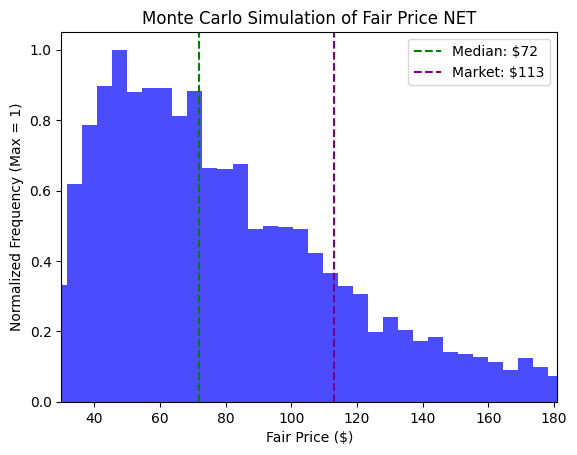

In [164]:
MonteCarloDCF("NET", 0.53, 0.3, 0.1).monteCarlo(5000)

Median fair price: $251
5th percentile fair price: $111
95th percentile fair price: $610
Market price: $378


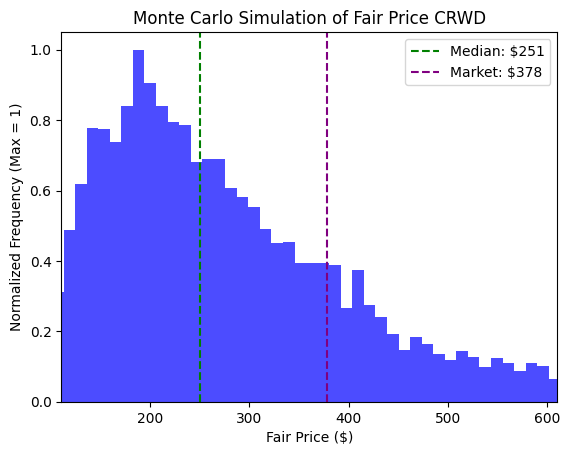

In [162]:
MonteCarloDCF("CRWD", 4.36, 0.28, 0.27).monteCarlo(5000)

Median fair price: $136
5th percentile fair price: $66
95th percentile fair price: $297
Market price: $173


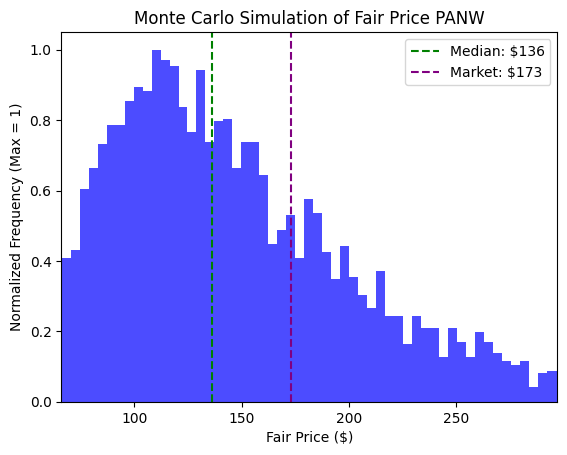

In [165]:
MonteCarloDCF("PANW", 4.93, 0.15, 0.38).monteCarlo(5000)

Median fair price: $315
5th percentile fair price: $133
95th percentile fair price: $780
Market price: $350


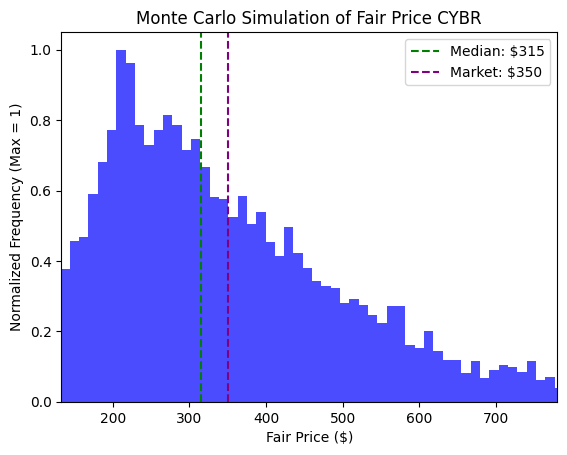

In [166]:
MonteCarloDCF("CYBR", 5, 0.3, 0.22).monteCarlo(5000)

Median fair price: $75
5th percentile fair price: $32
95th percentile fair price: $189
Market price: $62


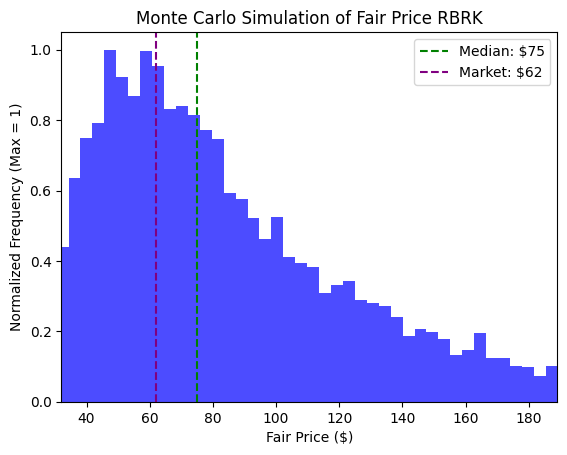

In [167]:
MonteCarloDCF("RBRK", 0.33, 0.3, 0.06).monteCarlo(5000)

Median fair price: $40
5th percentile fair price: $16
95th percentile fair price: $115
Market price: $92


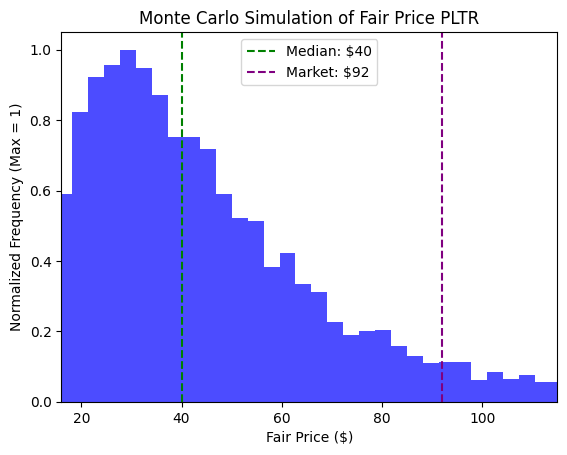

In [168]:
MonteCarloDCF("PLTR", 0.55, 0.43, 0.44).monteCarlo(5000)